##  1. Scraping and Data Arrangement  - Toronto Project

### 1.1 Scraping from Wikipedia

In [29]:
#importing base libraries 
#to get data
import requests

#for scraping
from bs4 import BeautifulSoup

#base python libraries
import pandas as pd
import numpy as np

In [30]:
#get the entire html of the url as a str
wikipedia_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [31]:
canada_data = BeautifulSoup(wikipedia_url, 'html.parser') #text to html

In [32]:
info_table = canada_data.find('table', class_ = 'wikitable')
rows_selected = info_table.find_all('tr')

In [33]:
# extract the info ('Postcode', 'Borough', 'Neighbourhood') from the table
canada_info = []
for row in rows_selected:
    info = row.text.split('\n')[1:-1] # remove empty str (first and last items)
    canada_info.append(info)
    
canada_info[:]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M7A', 'Downtown Toronto', "Queen's Park"],
 ['M8A', 'Not assigned', 'Not assigned'],
 ['M9A', "Queen's Park", 'Not assigned'],
 ['M1B', 'Scarborough', 'Rouge'],
 ['M1B', 'Scarborough', 'Malvern'],
 ['M2B', 'Not assigned', 'Not assigned'],
 ['M3B', 'North York', 'Don Mills North'],
 ['M4B', 'East York', 'Woodbine Gardens'],
 ['M4B', 'East York', 'Parkview Hill'],
 ['M5B', 'Downtown Toronto', 'Ryerson'],
 ['M5B', 'Downtown Toronto', 'Garden District'],
 ['M6B', 'North York', 'Glencairn'],
 ['M7B', 'Not assigned', 'Not assigned'],
 ['M8B', 'Not assigned', 'Not assigned'],
 ['M9B', 'Etobicoke', 'Cloverdale'],
 ['M9B', 'Etobicoke', 'Islington'],
 ['M9B',

In [34]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [35]:
#table (lists of list) to df

canada_info[0][-1] = 'Neighborhood'
canada_df = pd.DataFrame(canada_info[1:], columns=canada_info[0])

canada_df.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### 1.2. Data Arrangement 

In [36]:
not_assigned_boroughs = canada_df.index[canada_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = canada_df.index[canada_df['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods
print('initial rows and columns:', canada_df.shape)
print('boroughs miss value:', not_assigned_boroughs.shape[0])
print('neighborhoods miss value:', not_assigned_neighborhoods.shape[0])
print('boroughs and neighborhoods miss value:', not_assigned_neighborhoods_and_borough.shape[0])

initial rows and columns: (287, 3)
boroughs miss value: 77
neighborhoods miss value: 78
boroughs and neighborhoods miss value: 77


In [37]:
# drop not_assigned and reseting index
canada_df.drop(canada_df.index[not_assigned_boroughs], inplace=True)
canada_df.reset_index(drop=True, inplace=True)
canada_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Downtown Toronto,Queen's Park
6,M9A,Queen's Park,Not assigned
7,M1B,Scarborough,Rouge
8,M1B,Scarborough,Malvern
9,M3B,North York,Don Mills North


In [38]:
# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

# run this again because the indexes on the dataframe where reset
not_assigned_neighborhoods = canada_df.index[canada_df['Neighborhood'] == 'Not assigned']

for j in not_assigned_neighborhoods:
    canada_df['Neighborhood'][j] = canada_df['Borough'][j]
    
canada_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Downtown Toronto,Queen's Park
6,M9A,Queen's Park,Queen's Park
7,M1B,Scarborough,Rouge
8,M1B,Scarborough,Malvern
9,M3B,North York,Don Mills North


Combining repeated postal code area

In [43]:
group = canada_df.groupby('Postcode')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postcode', 'Borough', 'Neighborhood']

grouped_df.head(10)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


Shape verification:

In [47]:
grouped_df.shape

(103, 3)

***

## 2. Reading the geographical coordinates link/csv file of each postal code

In [46]:
cor_df = pd.read_csv('https://cocl.us/Geospatial_data')
cor_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [52]:
# creating coordinates columns based on postal codes
canada_df2 = grouped_df.join(cor_df.set_index('Postal Code'), on='Postcode')
canada_df2.head(12)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


***

## 3. Exploring and clustering the neighborhoods in Toronto

In this part, we are going to do 3 things:

- We are going to visualize the map of each neighborhood using Folium
- We are going to analyze the number of venues in each neighborhood
- We are going to get the top 3 venues in each neighborhood (based on the frequency)

This sort of information would be useful for the final capstone project in order to define a kind of market research to identify the neighborhoods that could be ideal for doing business of one type rather than other.

Installing Geopy in my personal Framework

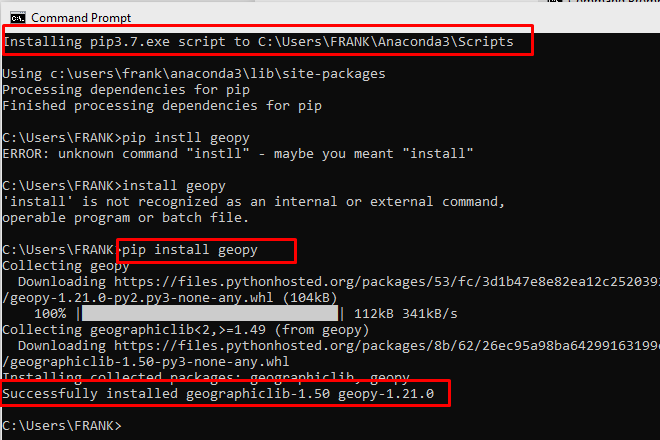

Installing Folium in my personal Framework

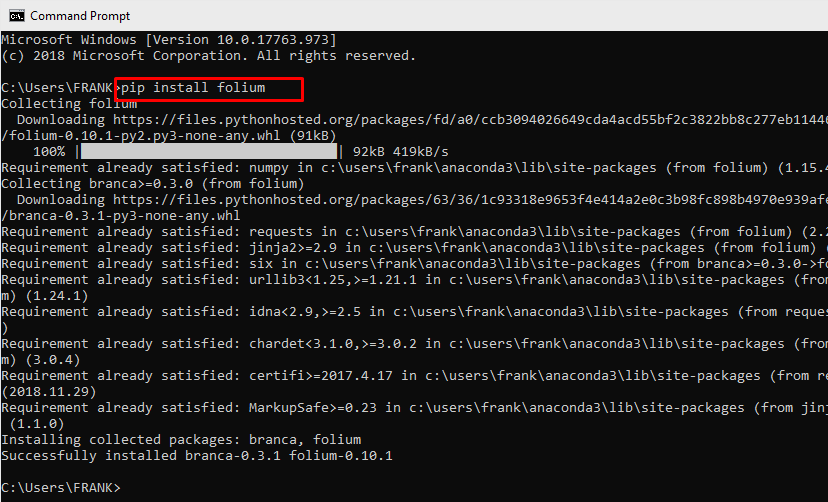

### 3.1. Creting a Toronto Map with all the neighborhoods

In [132]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np # library to handle data in a vectorized manner

In [60]:
# getting the coordinates of toronto 

location = Nominatim(user_agent="ny_explorer").geocode('Toronto')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


In [65]:
# generating the map of Canada using coordinates
map_tor = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(canada_df2['Latitude'], canada_df2['Longitude'], canada_df2['Borough'], canada_df2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

### 3.2. Foursquare API to explore the neighborhoods:

In [194]:
CLIENT_ID = 'AW532KHX12WPNYVJZ4GRG1HJ1SEOFY5H35LGLLWQQ24SZOZ0' # your Foursquare ID
CLIENT_SECRET = 'F5X1XRL32HAIJCNKOQ3ZADFOTK14AWJBWJCLEHF3LLQOVXSW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AW532KHX12WPNYVJZ4GRG1HJ1SEOFY5H35LGLLWQQ24SZOZ0
CLIENT_SECRET:F5X1XRL32HAIJCNKOQ3ZADFOTK14AWJBWJCLEHF3LLQOVXSW


In [195]:
# exloring the last neighborhood
canada_df2.loc[canada_df2.shape[0]-1, 'Neighborhood']

'Northwest'

In [196]:
#Get the neighborhood's latitude and longitude values.

neighborhood_latitude = canada_df2.loc[canada_df2.shape[0]-1, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = canada_df2.loc[canada_df2.shape[0]-1, 'Longitude'] # neighborhood longitude value

neighborhood_name = canada_df2.loc[canada_df2.shape[0]-1, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} is/are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Northwest is/are 43.706748299999994, -79.5940544.


Now, let's get the top 50 venues that are in the selected neigh. within a radius of 700 meters

In [197]:
LIMIT = 50 # limit of number of venues returned by Foursquare API

radius = 700 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=AW532KHX12WPNYVJZ4GRG1HJ1SEOFY5H35LGLLWQQ24SZOZ0&client_secret=F5X1XRL32HAIJCNKOQ3ZADFOTK14AWJBWJCLEHF3LLQOVXSW&v=20180605&ll=43.706748299999994,-79.5940544&radius=700&limit=50'

In [198]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e38df0d949393001bdc9041'},
 'response': {'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 43.7130483063, 'lng': -79.5853555934397},
   'sw': {'lat': 43.700448293699985, 'lng': -79.60275320656031}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5273f6f311d2137549494e29',
       'name': 'Economy Rent A Car',
       'location': {'lat': 43.708471,
        'lng': -79.589943,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.708471,
          'lng': -79.589943}],
        'distance': 382,
        'cc': 'CA',
        'country': 'Canada',
        'formattedAddress': ['Canada']},
       'categories': [{'id': '4bf58

In [199]:
# function that extracts the category of each venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [200]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Economy Rent A Car,Rental Car Location,43.708471,-79.589943
1,Saand Rexdale,Drugstore,43.705072,-79.598725
2,Sparkleen,Home Service,43.703184,-79.588370
3,Woodbine Hotel & Suites,Hotel,43.712624,-79.592664


As we can see, this return the four venues: 

In [201]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


Now, we are going to explore all the neigh. using the same process:

In [202]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [204]:
toronto_venues = getNearbyVenues(names=canada_df2['Neighborhood'],
                                   latitudes=canada_df2['Latitude'],
                                   longitudes=canada_df2['Longitude'])

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [205]:
# df with the venues in each neighborhood

toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",50,50,50,50,50,50
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",9,9,9,9,9,9
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Downsview North, Wilson Heights",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
Berczy Park,50,50,50,50,50,50


Now, we are going to find the most 3 common venues in each neighborhood.

In [206]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])

toronto_grouped = toronto_onehot[fixed_columns].groupby('Neighborhood').mean().reset_index() #mean of frequency

In [207]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [208]:
#dataframe for the top 3 venues in each neighborhood
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head() #this is the most important dataframe

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,"Adelaide, King, Richmond",Steakhouse,Asian Restaurant,Café
1,Agincourt,Latin American Restaurant,Breakfast Spot,Lounge
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Women's Store
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Beer Store,Fried Chicken Joint
4,"Alderwood, Long Branch",Pizza Place,Skating Rink,Sandwich Place


Finally, we are going to define our clusters using k-means and plot each cluster in a map:

In [209]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 4, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 4, 0, 0, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4])

In [210]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = canada_df2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,2.0,Fast Food Restaurant,Women's Store,Ethiopian Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1.0,Bar,Women's Store,Ethiopian Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Electronics Store,Breakfast Spot,Mexican Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean Restaurant,Mexican Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Fried Chicken Joint,Gas Station,Bank


In [211]:
toronto_merged["Cluster Labels"] = toronto_merged["Cluster Labels"].fillna(toronto_merged["Cluster Labels"].mean()).astype(int)

In [213]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'],
                                  toronto_merged['Longitude'],
                                  toronto_merged['Neighborhood'],
                                  toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters